# Named Entity Recognition with HMM  

In [5]:
from io import open

from nltk import FreqDist
from nltk import WittenBellProbDist
from nltk.util import bigrams
from conllu import parse_incr
import numpy as np
import pandas as pd

CHOOSE LANGUAGE from corpora below

In [6]:
lang = 'tr'

corpora = {}
corpora['en'] = 'UD_English-EWT/en_ewt'
corpora['tr'] = 'UD_Turkish-Kenet/tr_kenet'

In [7]:
def train_corpus(lang):
	return corpora[lang] + '-ud-train.conllu'

def test_corpus(lang):
	return corpora[lang] + '-ud-test.conllu'

# Remove contractions such as "isn't".
def prune_sentence(sent):
	return [token for token in sent if type(token['id']) is int]

def conllu_corpus(path):
	data_file = open(path, 'r', encoding='utf-8')
	sents = list(parse_incr(data_file))
	return [prune_sentence(sent) for sent in sents]

Limit length of sentences to avoid underflow.

In [8]:
max_len = 100

Get sentences for training and testing 

In [9]:
train_sents = conllu_corpus(train_corpus(lang))
test_sents = conllu_corpus(test_corpus(lang))
test_sents = [sent for sent in test_sents if len(sent) <= max_len]
print(len(train_sents), 'training sentences')
print(len(test_sents), 'test sentences')

15398 training sentences
1643 test sentences


TRAINING DATA in tuple - Gives a tuple of words and tags

In [10]:
def get_words_and_tags(sentences):
    words = []
    tags = []
    for sent in sentences:
	    for token in sent:
		    words.append(token['form'])
		    tags.append(token['upos'])
    # put it in the list of tuples
    list_of_tup = list(zip(words,tags))
    return list_of_tup

Returns lemmas from a given corpora

In [11]:
def get_lemmas(sentences):
    lemmas=[]
    for sent in sentences:
        for token in sent:
            lemmas.append(token['lemma'])
    return lemmas

BIGRAMS of training tags - This function creates bigrams from our training set and adds tags for begining and end of the sentence

In [12]:
def bigrams_tags_begend(train_sents):
    start = '<s>'
    end = '</s>'
    tags = []
    for sent in train_sents:
        tags.append(start)
        for token in sent:
            tags.append(token['upos'])
        tags.append(end)
    tags_bigrams = list(bigrams(tags))
    return tags_bigrams

EMISSION, Counts for Emission probability. Returns: Emission probability. Calculated by count of the word marked by the given tag and count of that tag

In [13]:
def emission_by_count(train_words_tags, given_word, given_tag):
    word_selection = [word for (word, tag) in train_words_tags if word == given_word and tag==given_tag]
    word_count = len(word_selection)
    tag_selection = [tag for (word, tag) in train_words_tags if tag==given_tag]
    tag_count = len(tag_selection)
    return (word_count/tag_count)

SMOOTH EMISSION

In [14]:
def emission_by_smoothing(train_words_tags):
    smoothed = {}
    uniqueTags = set([t for (_,t) in train_words_tags])
    for tag in uniqueTags:
        words = [w for (w,t) in train_words_tags if t == tag]
        smoothed[tag] = WittenBellProbDist(FreqDist(words), bins=1e5)
    return smoothed

To calculate emission probability for particular word and tag in test set

In [15]:
def emission_smoothed_proba(smoothed, given_word, given_tag):
    return smoothed[given_tag].prob(given_word)

TRANSITION

In [16]:
def transition_by_count(train_tags_bigrams, tag1, tag2):
    tag1_tag2 = [pair for pair in train_tags_bigrams if pair[0]==tag1 and pair[1]==tag2]
    tag1_tag2_count = len(tag1_tag2)
    tag1_occurance = [t1 for t1,t2 in train_tags_bigrams if t1 == tag1]
    tag1_count = len(tag1_occurance)
    return (tag1_tag2_count/tag1_count)

SMOOTH TRANSITION - Where tag1 is preceeding, tag2 is current tag

In [17]:
def transition_by_smoothing(train_tags_bigrams):
    smoothed = {}
    uniqueTags = set([t for (t,_) in train_tags_bigrams])
    for tag1 in uniqueTags:
        tag2 = [t2 for (t1,t2) in train_tags_bigrams if t1 == tag1]
        smoothed[tag1] = WittenBellProbDist(FreqDist(tag2), bins=1e5)
    return smoothed

To calculate transition probability for particular word and tag in test set

In [18]:
def transition_smoothed_proba(smoothed, given_tag1, given_tag2):
    return smoothed[given_tag1].prob(given_tag2)

Prints transition matrix

In [19]:
def print_transition_matrix(train_tags_bigrams, tags):
    smoothed = transition_by_smoothing(train_tags_bigrams)
    tags.insert(0,'<s>')
    tags.append('</s>')
    transition_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
    for tag1 in tags:
        for tag2 in tags:
            transition_matrix[tags.index(tag1), tags.index(tag2)] = transition_smoothed_proba(smoothed, tag1, tag2)
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    tags_df = pd.DataFrame(transition_matrix, columns = list(tags), index=list(tags))
    print(tags_df)

VITERBI algorithm

In [20]:
def Viterbi(test_sents, train_words_tags, train_tags_bigrams):
    smoothed_transition = transition_by_smoothing(train_tags_bigrams)
    smoothed_emission = emission_by_smoothing(train_words_tags)
    predicted_tags=[]
    words_to_tag = []
    tags = list(set([t for w,t in train_words_tags]))
    print(f'Unique tags: {tags}')

    # Take training sentences and put them into words, the algorithm takes sentences and run algorithm on them one by one
    for sent in test_sents:
        words = []
        for token in sent:
            words.append(token['form'])
            words_to_tag.append(token['form'])

        # Creates viterbi matrix that contains cells that have 2 values in them, first one is probability of that cell and second one is index of previous tag
        cols = len(words)
        rows = len(tags)
        viterbi_matrix = np.zeros((rows,cols,2))

        # Initialise first column of the matrix
        for current_tag_index in range(0, len(tags)):
            viterbi_matrix[current_tag_index, 0, 0] =  transition_smoothed_proba(smoothed_transition, '<s>',tags[current_tag_index])*emission_smoothed_proba(smoothed_emission, words[0],
             tags[current_tag_index])
            viterbi_matrix[current_tag_index, 0, 1] = 0 #here it does not matter what number it has because previous tag is <s> start of the sentence and it will never be considered
        for word_index in range(1, len(words)):
            for current_tag_index in range(len(tags)):
                cell_proba = [] # represents cell and inside goes all the probabilities gained from previous column that have same order as tags => its index will give us index of te tag later
                for previous_tag_index in range(len(tags)):
                    cell_proba.append(viterbi_matrix[previous_tag_index, word_index-1, 0]*transition_smoothed_proba(smoothed_transition, tags[previous_tag_index],tags[current_tag_index]))
                max_cell_proba = max(cell_proba)
                max_cell_tag_index = cell_proba.index(max_cell_proba) # as mentioned columns in the matrix are indexed in the same way the tags
                viterbi_matrix[current_tag_index, word_index, 0] = max_cell_proba*emission_smoothed_proba(smoothed_emission, words[word_index], tags[current_tag_index])
                viterbi_matrix[current_tag_index, word_index, 1] = max_cell_tag_index
        last_proba = []
        # Final calculation of probability and terminating Veterbi algorithm
        for previous_tag_index in range(len(tags)):
            last_proba.append(viterbi_matrix[previous_tag_index, len(words)-1,0]*transition_smoothed_proba(smoothed_transition, tags[previous_tag_index],'</s>'))
        max_last_proba = max(last_proba)
        max_last_tag_index = last_proba.index(max_last_proba)

        # Backtracking
        backtrack = []
        predicted_tag_index =max_last_tag_index
        backtrack.append(tags[predicted_tag_index])
        for column in range(len(words)-1,0,-1): # This goes back column by column
            predicted_tag_index = int(viterbi_matrix[predicted_tag_index, column, 1])
            backtrack.append(tags[predicted_tag_index])
        backtrack.reverse()
        for t in backtrack:
            predicted_tags.append(t)

    print("Predicted words:", len(words_to_tag))
    print("Predicted tags: ", len(predicted_tags))
    return list(zip(words_to_tag, predicted_tags))

TUPLE of training data - words and tags in tuple

In [21]:
train_words_tags = get_words_and_tags(train_sents)

 RUNNING Viterbi algorithm

In [22]:
test_words_tags = get_words_and_tags(test_sents)
test_correct_tags = [t for w,t in test_words_tags]
test_words = [w for w,t in test_words_tags]
train_tags_bigrams = bigrams_tags_begend(train_sents)
predicted_words_tags = Viterbi(test_sents, train_words_tags, train_tags_bigrams)
predicted_tags = [t for w,t in predicted_words_tags]

Unique tags: ['INTJ', 'SCONJ', 'PROPN', 'CCONJ', 'ADV', 'NOUN', 'VERB', 'DET', 'AUX', 'PUNCT', 'X', 'ADP', 'ADJ', 'NUM', 'PRON']
Predicted words: 17817
Predicted tags:  17817


 ACCURACY

In [23]:
check = [i for i, j in zip(predicted_tags, test_correct_tags) if i == j]
accuracy = len(check)/len(test_correct_tags)
print(f'Viterbi Algorithm Accuracy: {accuracy*100} %')

Viterbi Algorithm Accuracy: 88.64006286131223 %


Inspection of data

In [24]:
tags = [tag for (word, tag) in train_words_tags]
words = [word for (word, tag) in train_words_tags]
lemmas = get_lemmas(train_sents)
print("Number of words in training set: ", len(words))
print("Number of unique words in training set: ", len(set(words)))
print("Number of unique tags in training set: ", len(set(tags)))
print("Number of unique lemmas in training set: ", len(set(lemmas)))
print(f"Forms/Lemmas ratio: {len(set(words))/len(set(lemmas))}")
print_transition_matrix(train_tags_bigrams, list(set(tags)))

Number of words in training set:  143287
Number of unique words in training set:  42813
Number of unique tags in training set:  15
Number of unique lemmas in training set:  14062
Forms/Lemmas ratio: 3.0445882520267387
                <s>          INTJ         SCONJ         PROPN         CCONJ  \
<s>    9.733505e-09  8.693960e-03  1.362486e-03  5.917083e-02  1.505223e-02   
INTJ   4.546000e-07  2.651515e-02  4.546000e-07  4.545455e-02  7.575758e-03   
SCONJ  3.470413e-07  3.154574e-03  3.470413e-07  1.892745e-02  3.154574e-03   
PROPN  7.918140e-08  4.948045e-04  4.948045e-04  1.044038e-01  2.820386e-02   
CCONJ  3.944846e-08  7.888509e-04  2.629503e-04  1.840652e-02  1.866947e-02   
ADV    1.854294e-08  6.952491e-04  1.274623e-03  1.170336e-02  2.595597e-02   
NOUN   3.002526e-09  3.752557e-04  5.253579e-04  5.966565e-03  3.274105e-02   
VERB   9.417149e-09  1.883128e-03  1.153416e-02  1.588890e-03  3.166009e-02   
DET    2.067370e-08  1.590078e-04  2.067370e-08  3.498171e-03  3.816187

Find and output the most common tag

In [25]:
wordsFreq = FreqDist(words)
tagsFreq = FreqDist(tags)

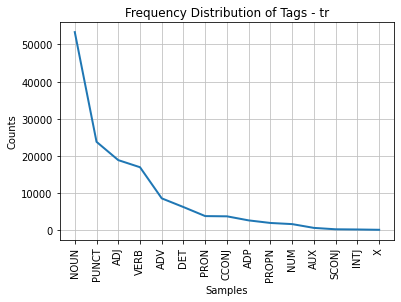

<AxesSubplot:title={'center':'Frequency Distribution of Tags - tr'}, xlabel='Samples', ylabel='Counts'>

In [27]:
tagsFreq.plot(title = f'Frequency Distribution of Tags - {lang}')